In [1]:
# Pytorch通常使用Dataset和DataLoader这两个工具类来构建数据管道。
# Dataset定义了数据集的内容，它相当于一个类似列表的数据结构，
# 具有确定的长度，能够用索引获取数据集中的元素。

# 而DataLoader定义了按batch加载数据集的方法，
# 它是一个实现了__iter__方法的可迭代对象，
# 每次迭代输出一个batch的数据。

# DataLoader能够控制batch的大小，batch中元素的采样方法，
# 以及将batch结果整理成模型所需输入形式的方法，
# 并且能够使用多进程读取数据。在绝大部分情况下，
# 用户只需实现Dataset的__len__方法和__getitem__方法，
# 就可以轻松构建自己的数据集，并用默认数据管道进行加载。

In [2]:
# 一，Dataset和DataLoader概述
# 1，获取一个batch数据的步骤
# 让我们考虑一下从一个数据集中获取一个batch的数据需要哪些步骤。
# (假定数据集的特征和标签分别表示为张量X和Y，数据集可以表示为(X,Y), 假定batch大小为m)

# 1，首先我们要确定数据集的长度n。
# 结果类似：n = 1000。

# 2，然后我们从0到n-1的范围中抽样出m个数(batch大小)。
# 假定m=4, 拿到的结果是一个列表，类似：indices = [1,4,8,9]

# 3，接着我们从数据集中去取这m个数对应下标的元素。
# 拿到的结果是一个元组列表，
# 类似：samples = [(X[1],Y[1]),(X[4],Y[4]),(X[8],Y[8]),(X[9],Y[9])]

# 4，最后我们将结果整理成两个张量作为输出。
# 拿到的结果是两个张量，类似batch = (features,labels) ，
# 其中 features = torch.stack([X[1],X[4],X[8],X[9]])
# labels = torch.stack([Y[1],Y[4],Y[8],Y[9]])

In [3]:
# 2，Dataset和DataLoader的功能分工
# 上述第1个步骤确定数据集的长度是由 Dataset的__len__ 方法实现的。

# 第2个步骤从0到n-1的范围中抽样出m个数的方法是由 
# DataLoader的 sampler和 batch_sampler参数指定的。
# sampler参数指定单个元素抽样方法，一般无需用户设置，
# 程序默认在DataLoader的参数shuffle=True时采用随机抽样，shuffle=False时采用顺序抽样。
# batch_sampler参数将多个抽样的元素整理成一个列表，一般无需用户设置，
# 默认方法在DataLoader的参数drop_last=True时会丢弃数据集
# 最后一个长度不能被batch大小整除的批次，在drop_last=False时保留最后一个批次。

# 第3个步骤的核心逻辑根据下标取数据集中的元素 是由 Dataset的 __getitem__方法实现的。

# 第4个步骤的逻辑由DataLoader的参数collate_fn指定。一般情况下也无需用户设置。

In [4]:
# 3，Dataset和DataLoader的主要接口
# 以下是 Dataset和 DataLoader的核心接口逻辑伪代码，不完全和源码一致。

import torch 
class Dataset(object):
    def __init__(self):
        pass
    
    def __len__(self):
        raise NotImplementedError
        
    def __getitem__(self,index):
        raise NotImplementedError
        

class DataLoader(object):
    def __init__(self,dataset,batch_size,collate_fn,shuffle = True,drop_last = False):
        self.dataset = dataset
        self.sampler =torch.utils.data.RandomSampler if shuffle else \
           torch.utils.data.SequentialSampler
        self.batch_sampler = torch.utils.data.BatchSampler
        self.sample_iter = self.batch_sampler(
            self.sampler(range(len(dataset))),
            batch_size = batch_size,drop_last = drop_last)
        
    def __next__(self):
        indices = next(self.sample_iter)
        batch = self.collate_fn([self.dataset[i] for i in indices])
        return batch

In [5]:
# 二，使用Dataset创建数据集
# Dataset创建数据集常用的方法有：

# 使用 torch.utils.data.TensorDataset 根据Tensor创建数据集
# (numpy的array，Pandas的DataFrame需要先转换成Tensor)。

# 使用 torchvision.datasets.ImageFolder 根据图片目录创建图片数据集。

# 继承 torch.utils.data.Dataset 创建自定义数据集。

# 此外，还可以通过
# torch.utils.data.random_split 将一个数据集分割成多份，
# 常用于分割训练集，验证集和测试集。
# 调用Dataset的加法运算符(+)将多个数据集合并成一个数据集。

In [6]:
import numpy as np 
import torch 
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split 

In [7]:
# 根据Tensor创建数据集

from sklearn import datasets 
iris = datasets.load_iris()
ds_iris = TensorDataset(torch.tensor(iris.data),torch.tensor(iris.target))

# 分割成训练集和预测集
n_train = int(len(ds_iris)*0.8)
n_valid = len(ds_iris) - n_train
ds_train,ds_valid = random_split(ds_iris,[n_train,n_valid])

print(type(ds_iris))
print(type(ds_train))

<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.utils.data.dataset.Subset'>


In [8]:
# 使用DataLoader加载数据集
dl_train,dl_valid = DataLoader(ds_train,batch_size = 8),DataLoader(ds_valid,batch_size = 8)

for features,labels in dl_train:
    print(features, labels)
    break

tensor([[5.4000, 3.0000, 4.5000, 1.5000],
        [7.7000, 3.8000, 6.7000, 2.2000],
        [4.9000, 3.1000, 1.5000, 0.2000],
        [6.8000, 3.0000, 5.5000, 2.1000],
        [4.4000, 2.9000, 1.4000, 0.2000],
        [6.1000, 2.6000, 5.6000, 1.4000],
        [6.0000, 2.9000, 4.5000, 1.5000],
        [6.3000, 2.9000, 5.6000, 1.8000]], dtype=torch.float64) tensor([1, 2, 0, 2, 0, 2, 1, 2])


In [9]:
# 演示加法运算符（`+`）的合并作用
ds_data = ds_train + ds_valid

print('len(ds_train) = ',len(ds_train))
print('len(ds_valid) = ',len(ds_valid))
print('len(ds_train+ds_valid) = ',len(ds_data))

print(type(ds_data))

len(ds_train) =  120
len(ds_valid) =  30
len(ds_train+ds_valid) =  150
<class 'torch.utils.data.dataset.ConcatDataset'>


In [10]:
# 2，根据图片目录创建图片数据集

import numpy as np 
import torch 
from torch.utils.data import DataLoader
from torchvision import transforms,datasets 
from PIL import Image

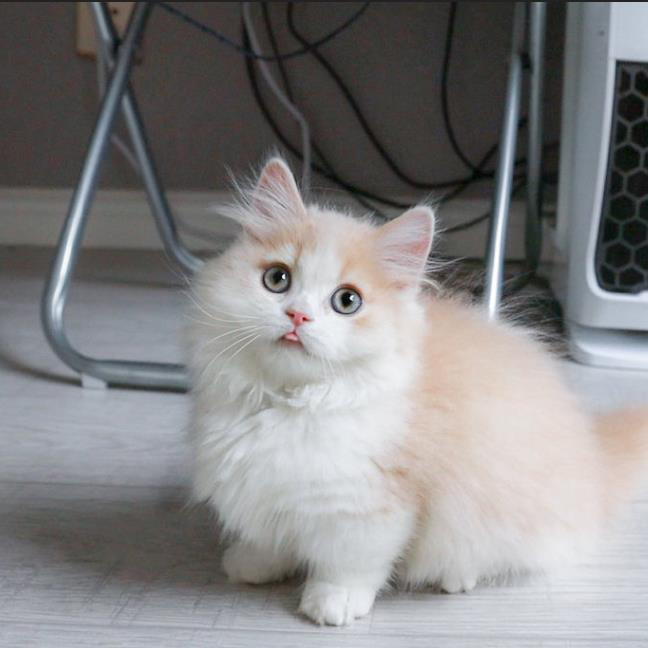

In [11]:
img = Image.open('../data/cat.jpg')
img

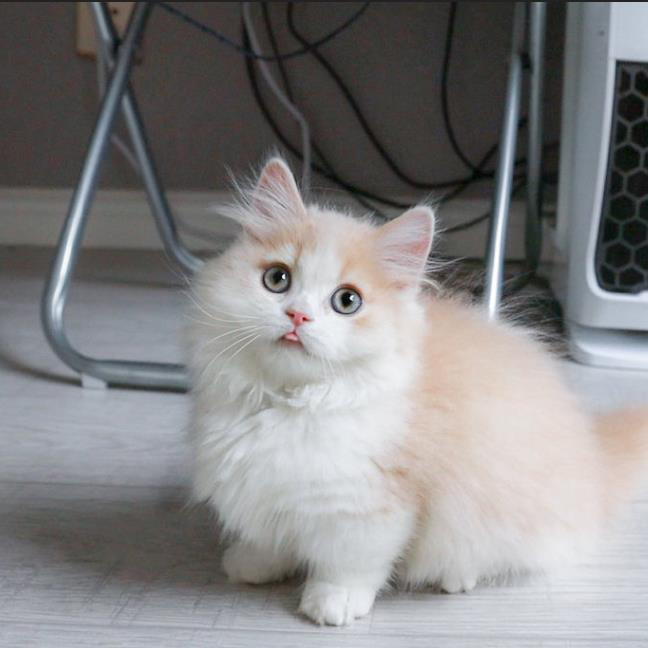

In [12]:
# 随机数值翻转
transforms.RandomVerticalFlip()(img)

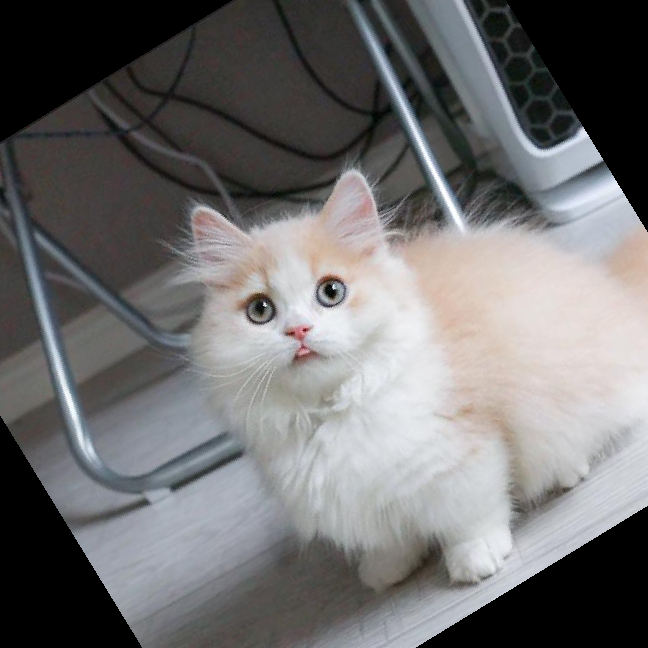

In [13]:
#随机旋转
transforms.RandomRotation(45)(img)

In [14]:
# 3，创建自定义数据集

# 下面通过继承Dataset类创建imdb文本分类任务的自定义数据集。

# 大概思路如下：首先，对训练集文本分词构建词典。然后将训练集文本和测试集文本数据转换成token单词编码。

# 接着将转换成单词编码的训练集数据和测试集数据按样本分割成多个文件，一个文件代表一个样本。

# 最后，我们可以根据文件名列表获取对应序号的样本内容，从而构建Dataset数据集。

In [17]:
import numpy as np 
import pandas as pd 
from collections import OrderedDict
import re,string

MAX_WORDS = 10000  # 仅考虑最高频的10000个词
MAX_LEN = 200  # 每个样本保留200个词的长度
BATCH_SIZE = 20 

train_data_path = '../data/imdb/train.tsv'
test_data_path = '../data/imdb/test.tsv'
train_token_path = '../data/imdb/train_token.tsv'
test_token_path =  '../data/imdb/test_token.tsv'
train_samples_path = '../data/imdb/train_samples/'
test_samples_path =  '../data/imdb/test_samples/'

In [18]:
##构建词典

word_count_dict = {}

#清洗文本
def clean_text(text):
    lowercase = text.lower().replace("\n"," ")
    stripped_html = re.sub('<br />', ' ',lowercase)
    cleaned_punctuation = re.sub('[%s]'%re.escape(string.punctuation),'',stripped_html)
    return cleaned_punctuation

with open(train_data_path,"r",encoding = 'utf-8') as f:
    for line in f:
        label,text = line.split("\t")
        cleaned_text = clean_text(text)
        for word in cleaned_text.split(" "):
            word_count_dict[word] = word_count_dict.get(word,0)+1 

df_word_dict = pd.DataFrame(pd.Series(word_count_dict,name = "count"))
df_word_dict = df_word_dict.sort_values(by = "count",ascending =False)

df_word_dict = df_word_dict[0:MAX_WORDS-2] #  
df_word_dict["word_id"] = range(2,MAX_WORDS) #编号0和1分别留给未知词<unkown>和填充<padding>

word_id_dict = df_word_dict["word_id"].to_dict()

df_word_dict.head(10)

,count,word_id
the,268230,2
and,129713,3
a,129479,4
of,116497,5
to,108296,6
is,85615,7
,84074,8
in,74715,9
it,62587,10
i,60837,11


In [19]:
# 然后我们利用构建好的词典，将文本转换成token序号。

In [20]:
#转换token

# 填充文本
def pad(data_list,pad_length):
    padded_list = data_list.copy()
    if len(data_list)> pad_length:
         padded_list = data_list[-pad_length:]
    if len(data_list)< pad_length:
         padded_list = [1]*(pad_length-len(data_list))+data_list
    return padded_list

def text_to_token(text_file,token_file):
    with open(text_file,"r",encoding = 'utf-8') as fin,\
      open(token_file,"w",encoding = 'utf-8') as fout:
        for line in fin:
            label,text = line.split("\t")
            cleaned_text = clean_text(text)
            word_token_list = [word_id_dict.get(word, 0) for word in cleaned_text.split(" ")]
            pad_list = pad(word_token_list,MAX_LEN)
            out_line = label+"\t"+" ".join([str(x) for x in pad_list])
            fout.write(out_line+"\n")
        
text_to_token(train_data_path,train_token_path)
text_to_token(test_data_path,test_token_path)

In [22]:
# 接着将token文本按照样本分割，每个文件存放一个样本的数据。

In [23]:
# 分割样本
import os

if not os.path.exists(train_samples_path):
    os.mkdir(train_samples_path)
    
if not os.path.exists(test_samples_path):
    os.mkdir(test_samples_path)
    
    
def split_samples(token_path,samples_dir):
    with open(token_path,"r",encoding = 'utf-8') as fin:
        i = 0
        for line in fin:
            with open(samples_dir+"%d.txt"%i,"w",encoding = "utf-8") as fout:
                fout.write(line)
            i = i+1

split_samples(train_token_path,train_samples_path)
split_samples(test_token_path,test_samples_path)

In [25]:
print(os.listdir(train_samples_path)[0:100])

['11303.txt', '3644.txt', '19987.txt', '18441.txt', '5235.txt', '17772.txt', '1053.txt', '13514.txt', '8711.txt', '15165.txt', '7422.txt', '8077.txt', '15603.txt', '7344.txt', '1735.txt', '13272.txt', '9369.txt', '18327.txt', '5553.txt', '17014.txt', '4895.txt', '11465.txt', '3122.txt', '19039.txt', '5547.txt', '18333.txt', '17000.txt', '4881.txt', '2228.txt', '11471.txt', '3136.txt', '4659.txt', '15617.txt', '8063.txt', '7350.txt', '12178.txt', '1721.txt', '13266.txt', '14509.txt', '6728.txt', '1047.txt', '13500.txt', '15171.txt', '8705.txt', '7436.txt', '16478.txt', '11317.txt', '3650.txt', '19993.txt', '10009.txt', '5221.txt', '18455.txt', '17766.txt', '3888.txt', '6700.txt', '14247.txt', '9433.txt', '13528.txt', '12636.txt', '15159.txt', '16450.txt', '4117.txt', '19763.txt', '3678.txt', '17996.txt', '2566.txt', '10021.txt', '5209.txt', '17028.txt', '2200.txt', '10747.txt', '11459.txt', '16336.txt', '4671.txt', '19005.txt', '7378.txt', '12150.txt', '1709.txt', '6066.txt', '14521.txt

In [26]:
# 一切准备就绪，我们可以创建数据集Dataset, 从文件名称列表中读取文件内容了。

In [27]:
import os
class imdbDataset(Dataset):
    def __init__(self,samples_dir):
        self.samples_dir = samples_dir
        self.samples_paths = os.listdir(samples_dir)
    
    def __len__(self):
        return len(self.samples_paths)
    
    def __getitem__(self,index):
        path = self.samples_dir + self.samples_paths[index]
        with open(path,"r",encoding = "utf-8") as f:
            line = f.readline()
            label,tokens = line.split("\t")
            label = torch.tensor([float(label)],dtype = torch.float)
            feature = torch.tensor([int(x) for x in tokens.split(" ")],dtype = torch.long)
            return  (feature,label)

In [28]:
ds_train = imdbDataset(train_samples_path)
ds_test = imdbDataset(test_samples_path)

In [29]:
print(len(ds_train))
print(len(ds_test))

20000
5000


In [ ]:
dl_train = DataLoader(ds_train,batch_size = BATCH_SIZE,shuffle = True,num_workers=4)
dl_test = DataLoader(ds_test,batch_size = BATCH_SIZE,num_workers=4)

if __name__ == "__main__":
    for features,labels in dl_train:
    print(features)
    print(labels)
    break

In [31]:
import torch
from torch import nn 
import importlib 
from torchkeras import Model,summary

class Net(Model):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量
        self.embedding = nn.Embedding(num_embeddings = MAX_WORDS,embedding_dim = 3,padding_idx = 1)
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1",nn.Conv1d(in_channels = 3,out_channels = 16,kernel_size = 5))
        self.conv.add_module("pool_1",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_1",nn.ReLU())
        self.conv.add_module("conv_2",nn.Conv1d(in_channels = 16,out_channels = 128,kernel_size = 2))
        self.conv.add_module("pool_2",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_2",nn.ReLU())
        
        self.dense = nn.Sequential()
        self.dense.add_module("flatten",nn.Flatten())
        self.dense.add_module("linear",nn.Linear(6144,1))
        self.dense.add_module("sigmoid",nn.Sigmoid())
        
    def forward(self,x):
        x = self.embedding(x).transpose(1,2)
        x = self.conv(x)
        y = self.dense(x)
        return y
        
model = Net()
print(model)

model.summary(input_shape = (200,),input_dtype = torch.LongTensor)

Net(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 200, 3]          30,000
            Conv1d-2              [-1, 16, 196]             256
         MaxPool1d-3               [-1, 16, 98]               0
              ReLU-4               [-1, 16, 98]               0
            Conv1d-5      

In [32]:
# 编译模型
def accuracy(y_pred,y_true):
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                      torch.zeros_like(y_pred,dtype = torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc

model.compile(loss_func = nn.BCELoss(),optimizer= torch.optim.Adagrad(model.parameters(),lr = 0.02),
             metrics_dict={"accuracy":accuracy})

In [ ]:
# 训练模型
# if __name__ == "__main__":
dfhistory = model.fit(10,dl_train,dl_val=dl_test,log_step_freq= 200)

In [ ]:
# 三，使用DataLoader加载数据集

# DataLoader能够控制batch的大小，batch中元素的采样方法，以及将batch结果整理成模型所需输入形式的方法，并且能够使用多进程读取数据。

# DataLoader的函数签名如下。

In [ ]:
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None,
    multiprocessing_context=None,
)

In [ ]:
# 一般情况下，我们仅仅会配置 dataset, batch_size, shuffle, num_workers, drop_last这五个参数，其他参数使用默认值即可。

# DataLoader除了可以加载我们前面讲的 torch.utils.data.Dataset 外，还能够加载另外一种数据集 torch.utils.data.IterableDataset。

# 和Dataset数据集相当于一种列表结构不同，IterableDataset相当于一种迭代器结构。 它更加复杂，一般较少使用。

# dataset : 数据集
# batch_size: 批次大小
# shuffle: 是否乱序
# sampler: 样本采样函数，一般无需设置。
# batch_sampler: 批次采样函数，一般无需设置。
# num_workers: 使用多进程读取数据，设置的进程数。
# collate_fn: 整理一个批次数据的函数。
# pin_memory: 是否设置为锁业内存。默认为False，锁业内存不会使用虚拟内存(硬盘)，从锁业内存拷贝到GPU上速度会更快。
# drop_last: 是否丢弃最后一个样本数量不足batch_size批次数据。
# timeout: 加载一个数据批次的最长等待时间，一般无需设置。
# worker_init_fn: 每个worker中dataset的初始化函数，常用于 IterableDataset。一般不使用。

In [ ]:
#构建输入数据管道
ds = TensorDataset(torch.arange(1,50))
dl = DataLoader(ds,
                batch_size = 10,
                shuffle= True,
                num_workers=2,
                drop_last = True)
#迭代数据
for batch, in dl:
    print(batch)